# Chapter 3: Classification
Recall, the most common ML tasks are Regression and Classification.

## MNIST
- 70k small handwritten digits (1-9)
- the "Hello World" of ML
- Make a new algorithm? Test it on MNIST

Geron ML has its way of loading MNIST, it didn't work for me so I worked around it.

In [1]:
# Packages
import tensorflow as tf
import numpy as np

In [2]:
# Import mnist (formatted as dictionary)
d = tf.keras.datasets.mnist.load_data(
    path='mnist.npz')

# Convert mnist to np array
e = np.array(d, dtype=object)

In [3]:
# Training set

X_train = e[0][0]           # Train images
y_train = e[0][1]           # Train labels



# Test Set
X_test = e[1][0]      # Test images 
y_test = e[1][1]      # Test labels

In [4]:
# Dimensions of the arrays
print(f'X-shape: {X_train.shape}')
print(f'y-shape: {y_train.shape}')
print(f'X-test-shape: {X_test.shape}')
print(f'y-test-shape: {y_test.shape}')

X-shape: (60000, 28, 28)
y-shape: (60000,)
X-test-shape: (10000, 28, 28)
y-test-shape: (10000,)


MNIST has 70k rows and 784 columns; there are 70k images with pixels 28x28.

We can take a look at an image as such:

Note: .reshape() method may be necessary to create the image

In [5]:
import matplotlib.pyplot as plt

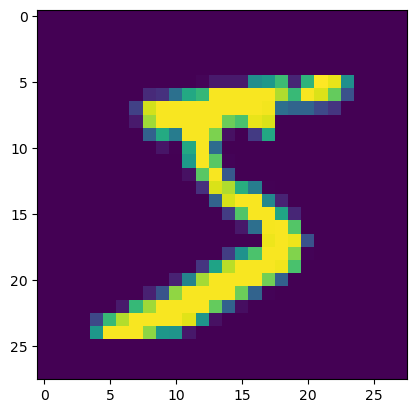

In [6]:
# Testing to see if X matches labels
plt.imshow(X_train[0].reshape(28,28))
plt.show()

In [7]:
# Label of the training instance X[0]
y_train[0]

5

We see from the `plt.imshow()` that the image is a **5**, and from the `y` at the same index that it is indeed a **5**

Let's look at another digit for fun:

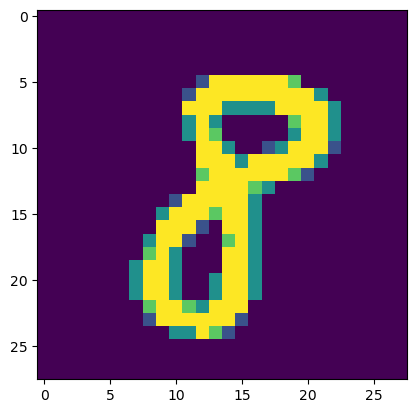

In [8]:
plt.imshow(X_train[245].reshape(28,28))

In [9]:
# Label of training instance X[245]
y_train[245]

8

Remark: **If the MNIST dataset wasn't already split into training/testing sets, we would need to split it ourselves.**

Remark: **MNIST is already shuffled, but if it wasn't we would need to because training algorithms are frequently sensetive to order and will end up creating an overfit model.** Shuffle the dataset to ensure proper training.

## Training a Binary Classifier
As a simple example: create a *binary* classifier that identifies **5** and **not 5**; a "5-detector"

In [12]:
# Create boolean arrays for training and testing sets of y values
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
# Showing boolean values
y_train_5[:5]

array([ True, False, False, False, False])

In [14]:
print(y_train_5.shape)
print(y_test_5.shape)

(60000,)
(10000,)


Since the dataset is large, use Stochastic Gradient Descent (SGD)

In [15]:
from sklearn.linear_model import SGDClassifier

In [16]:
# Stochastic Gradient Descent classifier
sgd_clf = SGDClassifier(random_state=42)

In [17]:
# Fit data and true/false values: X is training set, 
sgd_clf.fit(X_train.reshape(60000,28*28),y_train_5)

SGDClassifier(random_state=42)

In [18]:
# predict 5 at end of testing set (len(X_test)-2)
sgd_clf.predict(X_test[len(X_test)-2].reshape(1,28*28))
# Correctly predicts True

array([ True])

In [19]:
y_test[len(X_test)-2] # The "5-detector" predicted correctly!

5

## Performance Measures
Evaluation of a classifier is trickier than evaluation of a regressor.


### Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross validation.

The next example is a way to implement cross validation yourself without the built-in function:

In [20]:
####### IMPLEMENT CROSS VALIDATION FUNCTION YOURESELF ##################
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone # Constructs unfitted estimator with same parameters as argument

# Provides train-test indices
skfolds = StratifiedKFold(n_splits=3)


for train_index, test_index in skfolds.split(X_train.reshape(60000,28*28), y_train_5):
    clone_clf = clone(sgd_clf)
    print(train_index)
    # The folds vars contain subsets of datasets for validation
    X_train_folds = X_train[train_index].reshape(X_train[train_index].shape[0],28*28)
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index].reshape(X_train[test_index].shape[0],28*28)
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_test_folds == y_pred)
    print(n_correct/len(y_pred))
    
#########################################################################

[19964 19965 19966 ... 59997 59998 59999]
0.95035
[    0     1     2 ... 59997 59998 59999]
0.96035
[    0     1     2 ... 40088 40125 40127]
0.9604


Easier than creating a custom function is to use the `cross_val_score()` function to evaluate your classifier. `cross_val_score()` splits the training set into *K* folds (we will use 3), then make predictions and evaluate on each fold.

In [21]:
# Import the cross_val_score() function
from sklearn.model_selection import cross_val_score
# Train and evaluate on 3 folds (splits) using the 'accuracy' metric
cross_val_score(sgd_clf, X_train.reshape(60000,28*28), y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

The `cross_val_score()` gives us great results, except what if it's just not predicting 5 at all?

Next is an example of a "dumb" classifier that just never predicts 5:

In [22]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # Always predicts false
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train.reshape(60000,28*28), y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

The fact that we can just guess `FALSE` on everything is the reason why *accuracy* is not the preferred metric in classification. What if the dataset is skewed and 5 is represented as 50% of the datapoints? Then the same classifier only has 50% accuracy! This leads into classification metrics

## Confusion Matrix
A better way to look at classification performance.

"For example, to know the number of times the classifier confused images of 5 with 3, look at the $5^{th}$ row and $3^{rd}$ column of the Confusion Matrix.

